In [1]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

In [2]:
# Mengetahui lokasi dari penyimpanan
import os
os.getcwd()

'/Users/selvimelani/Documents/LEARNING FOR PORTOFOLIO/Project#ecommerce'

In [3]:
# Import data dari CSV ke DataFrame
df = pd.read_csv('Sales Transaction v.4a.csv', header=0)
df

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom
...,...,...,...,...,...,...,...,...
536345,C536548,12/1/2018,22168,Organiser Wood Antique White,18.96,-2,12472.0,Germany
536346,C536548,12/1/2018,21218,Red Spotty Biscuit Tin,14.09,-3,12472.0,Germany
536347,C536548,12/1/2018,20957,Porcelain Hanging Bell Small,11.74,-1,12472.0,Germany
536348,C536548,12/1/2018,22580,Advent Calendar Gingham Sack,16.35,-4,12472.0,Germany


In [4]:
# Mengetahui informasi dari data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionNo  536350 non-null  object 
 1   Date           536350 non-null  object 
 2   ProductNo      536350 non-null  object 
 3   ProductName    536350 non-null  object 
 4   Price          536350 non-null  float64
 5   Quantity       536350 non-null  int64  
 6   CustomerNo     536295 non-null  float64
 7   Country        536350 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.7+ MB


In [5]:
# Memeriksa jumlah nilai yang hilang (missing values) dalam DataFrame
# Karena nilai yang hilang dapat mempengaruhi hasil analisis yang digunakan
# Terdapat 55 nilai yang hilang dalam CustomerNo
df.isna().sum()

TransactionNo     0
Date              0
ProductNo         0
ProductName       0
Price             0
Quantity          0
CustomerNo       55
Country           0
dtype: int64

In [6]:
# Data Cleansing
df_clean = df.copy()

# Membuat kolom order_status dengan nilai 'Cancelled' jika TransactionNo diawali dengan huruf 'C' dan 'delivered' jika TransactionNo tanpa awalan huruf 'c'
df_clean['TransactionStatus'] = np.where(df_clean['TransactionNo'].str[:1]=='C', 'Cancelled', 'Delivered')

# Hapus huruf 'C' pada kolom 'TransactionNo' supaya lebih rapi dan terurut
df_clean['TransactionNo'] = df_clean['TransactionNo'].str.replace('C', '')

# Menghapus semua baris tanpa CustomerNo
df_clean = df_clean[~df_clean['CustomerNo'].isna()]

# Mengubah nilai quantity yang negatif menjadi positif karena nilai negatif tersebut hanya menandakan order tersebut cancelled
df_clean['Quantity'] = df_clean['Quantity'].abs()

# Menghapus baris dengan price bernilai negatif
df_clean = df_clean[df_clean['Price']>0]

# Membuat nilai Amount, yaitu perkalian antara Quantity dan Price
df_clean['Amount'] = df_clean['Quantity'] * df_clean['Price'] #dalam pound sterling (£)

# Mengubah CustomerNo dari Float menjadi int --> supaya tidak ada koma
df_clean['CustomerNo'].fillna(-1, inplace=True)
df_clean['CustomerNo'] = df_clean['CustomerNo'].astype('int64')

# Memastikan bahwa setiap 'ProductNo' memiliki nama produk yang konsisten (unik) yaitu nama produk yang paling sering muncul dalam dataset.
# Hal ini berguna untuk memperbaiki inkonsistensi dalam data
# Pertama-tama menghitung frekuensi kemunculan setiap nama produk untuk setiap produk
most_freq_product_name = df_clean.groupby(['ProductNo','ProductName'], as_index=False).agg(order_cnt=('TransactionNo','nunique')).sort_values(['ProductNo','order_cnt'], ascending=[True,False])
# Memberi peringkat pada setiap nama produk
most_freq_product_name['rank'] = most_freq_product_name.groupby('ProductNo')['order_cnt'].rank(method='first', ascending=False)
# Memilih nama produk yang sering muncul
most_freq_product_name = most_freq_product_name[most_freq_product_name['rank']==1].drop(columns=['order_cnt','rank'])
# Menggabungkan hasil dengan DataFrame utama
df_clean = df_clean.merge(most_freq_product_name.rename(columns={'ProductName':'most_freq_product_name'}), how='left', on='ProductNo')
# Mengganti nilai 'ProductName' dengan nama produk yang paling sering muncul
df_clean['ProductName'] = df_clean['most_freq_product_name']
# Menghapus kolom tambahan (most_freq_product_name) setelah digunakan
df_clean = df_clean.drop(columns='most_freq_product_name')

# mengkonversi kolom Date menjadi datetime
df_clean['Date'] = df_clean['Date'].astype('datetime64[ns]')

# membuat kolom year_month
df_clean['Year-Month'] = df_clean['Date'].dt.to_period('M')

# Menghapus outlier
from scipy import stats
# Menghitung Z-Score dan menghapus outlier
df_clean = df_clean[(np.abs(stats.zscore(df_clean[['Quantity','Amount']]))<3).all(axis=1)]  #nilai z score yang lebih dari tiga dianggap sebagai outlier
df_clean = df_clean.reset_index(drop=True)

df_clean


,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,TransactionStatus,Amount,Year-Month
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490,United Kingdom,Delivered,257.64,2019-12
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069,United Kingdom,Delivered,383.40,2019-12
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069,United Kingdom,Delivered,138.36,2019-12
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069,United Kingdom,Delivered,127.80,2019-12
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069,United Kingdom,Delivered,71.64,2019-12
...,...,...,...,...,...,...,...,...,...,...,...
535993,536548,2018-12-01,22168,Organiser Wood Antique White,18.96,2,12472,Germany,Cancelled,37.92,2018-12
535994,536548,2018-12-01,21218,Red Spotty Biscuit Tin,14.09,3,12472,Germany,Cancelled,42.27,2018-12
535995,536548,2018-12-01,20957,Porcelain Hanging Bell Small,11.74,1,12472,Germany,Cancelled,11.74,2018-12
535996,536548,2018-12-01,22580,Advent Calendar Gingham Sack,16.35,4,12472,Germany,Cancelled,65.40,2018-12


In [7]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535998 entries, 0 to 535997
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   TransactionNo      535998 non-null  object        
 1   Date               535998 non-null  datetime64[ns]
 2   ProductNo          535998 non-null  object        
 3   ProductName        535998 non-null  object        
 4   Price              535998 non-null  float64       
 5   Quantity           535998 non-null  int64         
 6   CustomerNo         535998 non-null  int64         
 7   Country            535998 non-null  object        
 8   TransactionStatus  535998 non-null  object        
 9   Amount             535998 non-null  float64       
 10  Year-Month         535998 non-null  period[M]     
dtypes: datetime64[ns](1), float64(2), int64(2), object(5), period[M](1)
memory usage: 45.0+ MB


In [8]:
df_clean.isna().sum()
# setelah dilakukan cleaning data, sudah tidak terdapat nilai yang hilang

TransactionNo        0
Date                 0
ProductNo            0
ProductName          0
Price                0
Quantity             0
CustomerNo           0
Country              0
TransactionStatus    0
Amount               0
Year-Month           0
dtype: int64

In [9]:
# memunculkan statistika deskriptif dari data
df_clean.describe()

,Price,Quantity,CustomerNo,Amount
count,535998.000000,535998.000000,535998.000000,535998.000000
mean,12.662756,9.718536,15227.534939,109.548277
std,8.492766,24.927986,1716.492592,275.016184
min,5.130000,1.000000,12004.000000,5.130000
25%,10.990000,1.000000,13805.000000,16.660000
50%,11.940000,3.000000,15152.000000,43.500000
75%,14.090000,10.000000,16729.000000,119.400000
max,660.620000,640.000000,18287.000000,6918.000000


/var/folders/mh/qyrs9lwx5kvb8hqbf7qcmnq40000gn/T/ipykernel_1275/1039871642.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(quantity_trend.index.strftime('%m-%Y')))


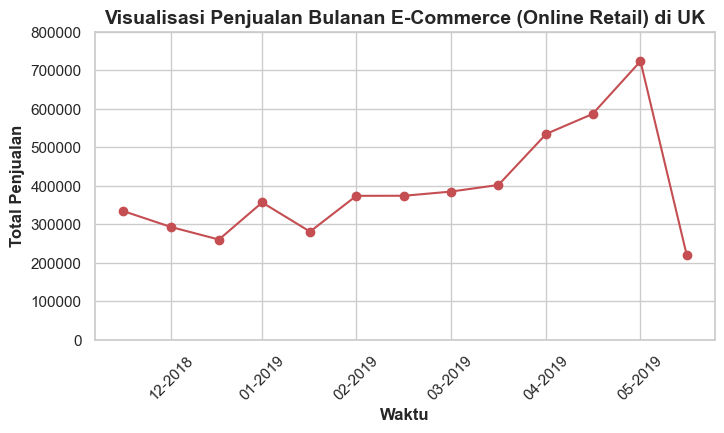

In [10]:
# Visualisasi: Grafik Garis Tren Penjualan Bulanan (Hanya untuk Transaction dengan status "Delivered")
# Tujuan: Menampilkan tren penjualan untuk mengidentifikasi fluktuasi penjualan dan tren musiman.

# Filter data untuk data penjualan yang berhasil
df_successful_sales = df_clean[df_clean['TransactionStatus'] == 'Delivered']  

# Mengelompokkan data berdasarkan periode bulanan dan menggunakan agregasi untuk menjumlahkan kolom 'Quantity'
quantity_trend = df_successful_sales.groupby(df_successful_sales['Date'].dt.to_period('M')).agg({'Quantity': 'sum'})

# Mengkonversi indeks periode (PeriodIndex) menjadi Timestamp (DatetimeIndex)
quantity_trend.index = quantity_trend.index.to_timestamp()

# Plot data
sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
plt.plot(quantity_trend.index, quantity_trend['Quantity'], marker='o', linestyle='-', color='r')
plt.title('Visualisasi Penjualan Bulanan E-Commerce (Online Retail) di UK', fontweight='bold', fontsize=14)
plt.xlabel('Waktu', fontweight='bold', fontsize=12)
plt.ylabel('Total Penjualan', fontweight='bold', fontsize=12)
plt.ylim(0, 800000)  # Batas sumbu y

# Format x-axis
plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(quantity_trend.index.strftime('%m-%Y')))
plt.xticks(rotation=45)

# Menampilkan grid
plt.grid(True)

# Menampilkan visualisasi
plt.show()


Sepuluh Negara dengan Penjualan Terbanyak:
Country
United Kingdom    4296303
Netherlands        190710
EIRE               148519
Germany            122202
France             119276
Australia           83477
Sweden              34082
Switzerland         31156
Spain               24608
Belgium             23795
Name: Quantity, dtype: int64


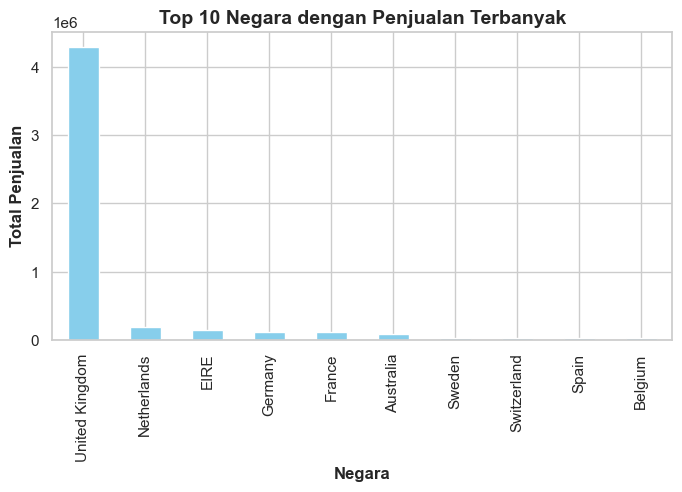

In [11]:
# Menghitung total penjualan barang (Quantity) untuk masing-masing negara
purchased_by_country = df_clean.groupby('Country')['Quantity'].sum().sort_values(ascending=False)  #menggunakan fungsi sum

# Mengambil 10 negara dengan penjualan terbanyak
top_10_countries = purchased_by_country.head(10)

# Visualisasi hasil
plt.figure(figsize=(8, 4))
top_10_countries.plot(kind='bar', color='skyblue')
print("Sepuluh Negara dengan Penjualan Terbanyak:")
print(top_10_countries)

# Menambahkan label dan judul
plt.xlabel('Negara', fontweight='bold', fontsize=12)
plt.ylabel('Total Penjualan', fontweight='bold', fontsize=12)
plt.title('Top 10 Negara dengan Penjualan Terbanyak', fontweight='bold', fontsize=14)

plt.show()

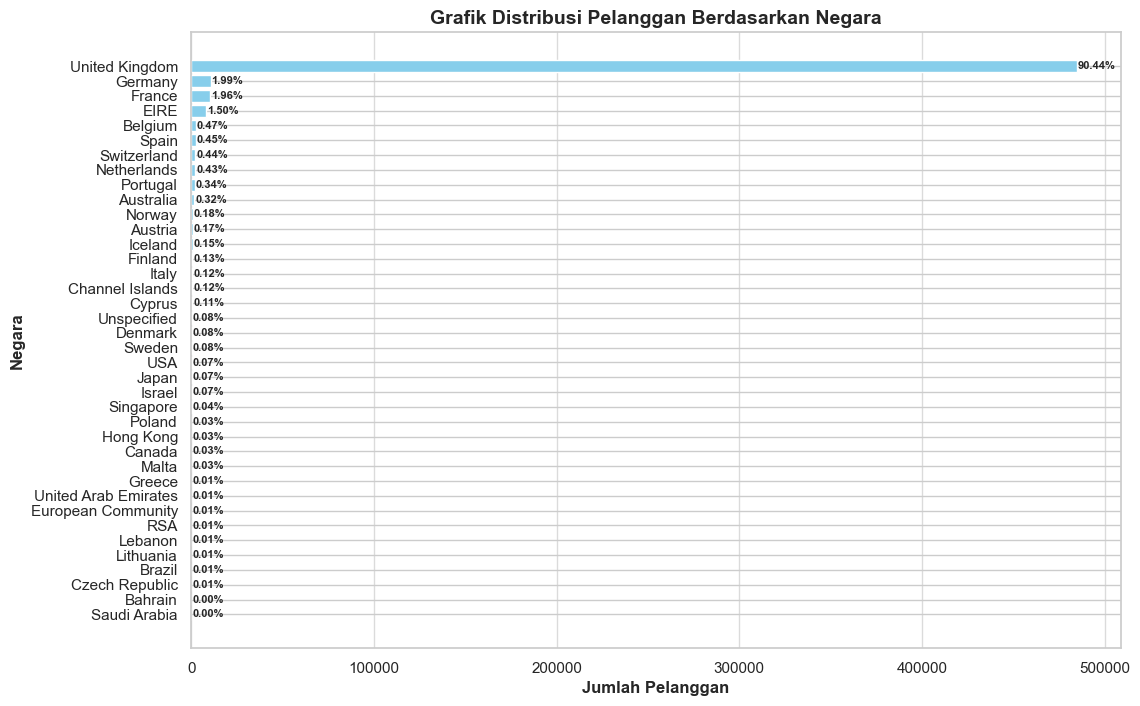

In [12]:
# Menghitung jumlah pelanggan per negara
customer_segment = df_clean.groupby('Country').size().sort_values(ascending=True)

# Menghitung persentase pelanggan per negara
total_customers = customer_segment.sum()
customer_percentage = (customer_segment / total_customers) * 100 #dikalikan dengan 100

# Membuat figure dengan ukuran tertentu
plt.figure(figsize=(12, 8))

# Membuat diagram batang horizontal
bars = plt.barh(customer_segment.index, customer_segment.values, color='skyblue')

# Menambahkan label dan judul
plt.xlabel('Jumlah Pelanggan', fontweight='bold', fontsize=12)
plt.ylabel('Negara', fontweight='bold', fontsize=12)
plt.title('Grafik Distribusi Pelanggan Berdasarkan Negara', fontweight='bold', fontsize=14)

# Menambahkan grid untuk sumbu x
plt.grid(axis='x', linestyle='-', alpha=0.7)

# Menambahkan nilai persentase di sebelah setiap batang
for bar, percentage in zip(bars, customer_percentage):
    plt.text(bar.get_width() + 500, bar.get_y() + bar.get_height()/2,
             f'{percentage:.2f}%', va='center', fontweight='bold', fontsize=8)

# Menampilkan plot
plt.show()

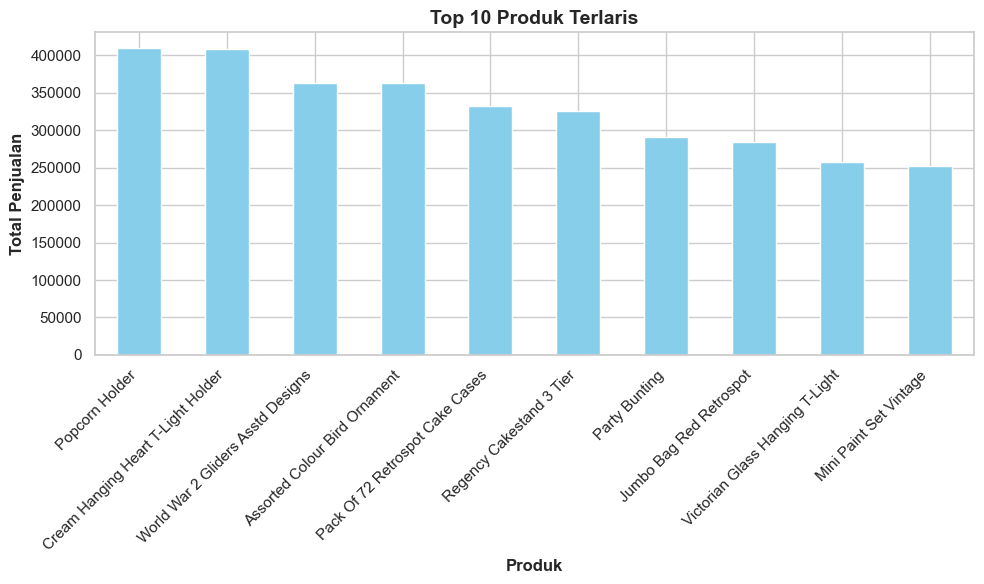

In [13]:
# 1. Hitung total penjualan untuk setiap produk
df_clean['TotalSales'] = df_clean['Quantity'] * df_clean['Price']
product_sales = df_clean.groupby('ProductName')['TotalSales'].sum().sort_values(ascending=False)

# 2. Identifikasi produk dengan penjualan tertinggi
top_products = product_sales.head(10)  # 10 produk terlaris

# Plot produk terlaris
plt.figure(figsize=(10, 6))
top_products.plot(kind='bar', color='skyblue')
plt.title('Top 10 Produk Terlaris', fontweight='bold', fontsize=14)
plt.xlabel('Produk', fontweight='bold', fontsize=12)
plt.ylabel('Total Penjualan', fontweight='bold', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# User Retention Cohort

User retention cohort digunakan untuk melihat tingkat retensi dari pengguna. Analisis ini dapat digunakan untuk menganalisis seberapa konsisten pengguna kembali bertransaksi.
Adapun langkah-langkah untuk membuat user retention cohort yaitu sebagai berikut:
1. Import data transaksi ke data frame
2. Melakukan data cleansing dan membuat kolom tahun dan bulan. Hal ini dilakukan untuk melihat pola dari transaksi bulanan.
3. Mengagregat data transaksi ke bentuk summary total transaksi/order dari setiap pengguna di setiap bulannya.
4. Membuat kolom sebagai cohort dari pengguna.
5. Menghitung jarak bulan antara bulan transaksi dengan bulan pertama kali bertransaksi dan menjumlahkan dengan 1.
6. Membuat tabel pivot.
7. Menghitung banyaknya pengguna di masing-masing cohort dan membuat retention rate.
8. Menampilkan tabel pivot yang sudah berisi nilai retention rate ke dalam heatmap.

In [14]:
df_user_monthly = df_clean.groupby(['CustomerNo','Year-Month'], as_index=False).agg(order_cnt=('TransactionNo','nunique'))
df_user_monthly

,CustomerNo,Year-Month,order_cnt
0,12004,2019-04,1
1,12006,2019-05,1
2,12008,2019-03,1
3,12013,2018-12,1
4,12024,2019-06,1
...,...,...,...
14733,18283,2019-10,1
14734,18283,2019-11,4
14735,18283,2019-12,1
14736,18287,2019-05,1


In [15]:
df_user_monthly['cohort'] = df_user_monthly.groupby('CustomerNo')['Year-Month'].transform('min')
df_user_monthly

,CustomerNo,Year-Month,order_cnt,cohort
0,12004,2019-04,1,2019-04
1,12006,2019-05,1,2019-05
2,12008,2019-03,1,2019-03
3,12013,2018-12,1,2018-12
4,12024,2019-06,1,2019-06
...,...,...,...,...
14733,18283,2019-10,1,2019-01
14734,18283,2019-11,4,2019-01
14735,18283,2019-12,1,2019-01
14736,18287,2019-05,1,2019-05


In [16]:
from operator import attrgetter

df_user_monthly['period_num'] = (df_user_monthly['Year-Month'] - df_user_monthly['cohort']).apply(attrgetter('n')) + 1
df_user_monthly

,CustomerNo,Year-Month,order_cnt,cohort,period_num
0,12004,2019-04,1,2019-04,1
1,12006,2019-05,1,2019-05,1
2,12008,2019-03,1,2019-03,1
3,12013,2018-12,1,2018-12,1
4,12024,2019-06,1,2019-06,1
...,...,...,...,...,...
14733,18283,2019-10,1,2019-01,10
14734,18283,2019-11,4,2019-01,11
14735,18283,2019-12,1,2019-01,12
14736,18287,2019-05,1,2019-05,1


In [17]:
df_cohort_pivot = pd.pivot_table(df_user_monthly, index='cohort', columns='period_num', values='CustomerNo', aggfunc=pd.Series.nunique)
df_cohort_pivot

period_num,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort,,,,,,,,,,,,,
2018-12,1081.0,378.0,339.0,394.0,374.0,406.0,396.0,371.0,354.0,410.0,396.0,519.0,275.0
2019-01,486.0,108.0,135.0,119.0,152.0,144.0,119.0,121.0,144.0,161.0,170.0,73.0,NaN
2019-02,432.0,103.0,80.0,112.0,113.0,98.0,106.0,116.0,106.0,133.0,38.0,NaN,NaN
2019-03,492.0,87.0,110.0,98.0,115.0,84.0,124.0,116.0,143.0,45.0,NaN,NaN,NaN
2019-04,319.0,69.0,64.0,62.0,64.0,76.0,71.0,83.0,29.0,NaN,NaN,NaN,NaN
2019-05,326.0,73.0,61.0,54.0,70.0,76.0,83.0,29.0,NaN,NaN,NaN,NaN,NaN
2019-06,267.0,55.0,47.0,60.0,62.0,75.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-07,210.0,36.0,37.0,45.0,64.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08,172.0,39.0,41.0,41.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
cohort_size = df_cohort_pivot.iloc[:, 0]
cohort_size

cohort
2018-12    1081.0
2019-01     486.0
2019-02     432.0
2019-03     492.0
2019-04     319.0
2019-05     326.0
2019-06     267.0
2019-07     210.0
2019-08     172.0
2019-09     284.0
2019-10     329.0
2019-11     286.0
2019-12      46.0
Freq: M, Name: 1, dtype: float64

In [19]:
df_retention_cohort = df_cohort_pivot.divide(cohort_size, axis=0)
df_retention_cohort

period_num,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort,,,,,,,,,,,,,
2018-12,1.0,0.349676,0.313599,0.364477,0.345976,0.375578,0.366327,0.343201,0.327475,0.379278,0.366327,0.480111,0.254394
2019-01,1.0,0.222222,0.277778,0.244856,0.312757,0.296296,0.244856,0.248971,0.296296,0.331276,0.349794,0.150206,NaN
2019-02,1.0,0.238426,0.185185,0.259259,0.261574,0.226852,0.245370,0.268519,0.245370,0.307870,0.087963,NaN,NaN
2019-03,1.0,0.176829,0.223577,0.199187,0.233740,0.170732,0.252033,0.235772,0.290650,0.091463,NaN,NaN,NaN
2019-04,1.0,0.216301,0.200627,0.194357,0.200627,0.238245,0.222571,0.260188,0.090909,NaN,NaN,NaN,NaN
2019-05,1.0,0.223926,0.187117,0.165644,0.214724,0.233129,0.254601,0.088957,NaN,NaN,NaN,NaN,NaN
2019-06,1.0,0.205993,0.176030,0.224719,0.232210,0.280899,0.112360,NaN,NaN,NaN,NaN,NaN,NaN
2019-07,1.0,0.171429,0.176190,0.214286,0.304762,0.104762,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08,1.0,0.226744,0.238372,0.238372,0.127907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


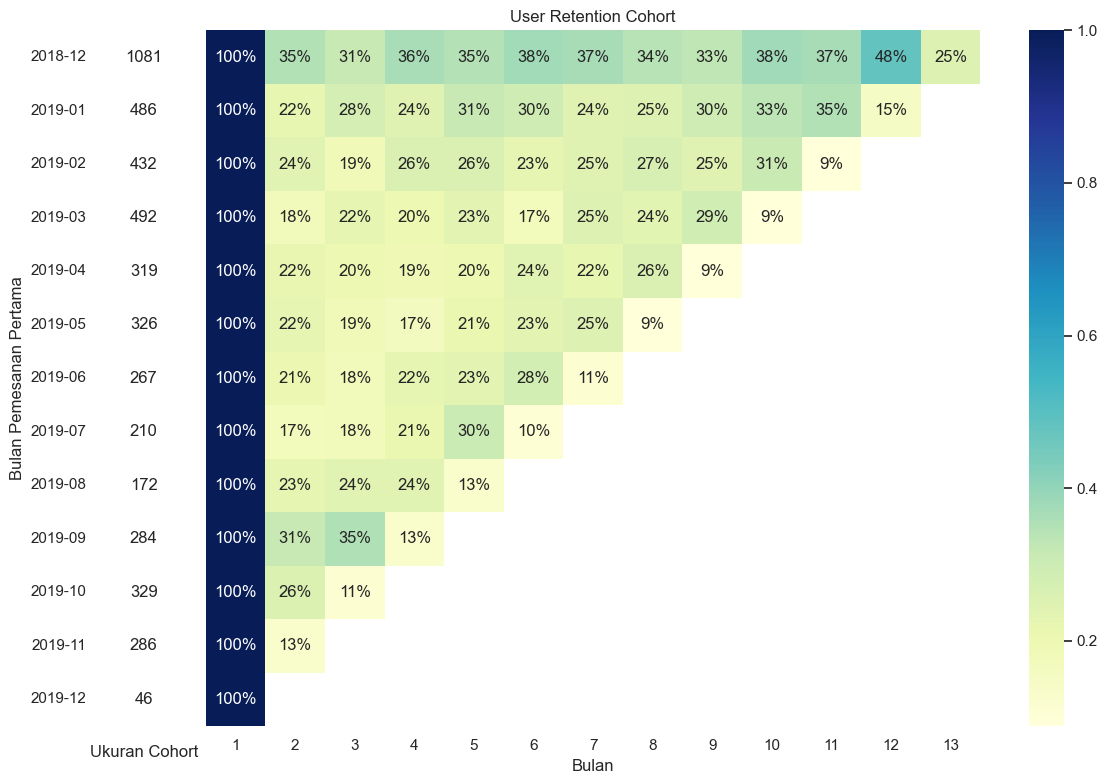

In [20]:

with sns.axes_style('white'):  #menyiapkan bakground warnanya dulu

    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios':[1, 11]}) #subplot --> dua plot dijadikan 1

    # user retention cohort
    sns.heatmap(df_retention_cohort, annot=True, fmt='.0%', cmap='YlGnBu', ax=ax[1])  #cmap --> warnanya
    ax[1].set_title('User Retention Cohort')
    ax[1].set(xlabel='Bulan', ylabel='')

    # cohort size
    df_cohort_size = pd.DataFrame(cohort_size)
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(df_cohort_size, annot=True, cbar=False, fmt='g', cmap=white_cmap, ax=ax[0])
    ax[0].tick_params(bottom=False)
    ax[0].set(xlabel='Ukuran Cohort', ylabel='Bulan Pemesanan Pertama', xticklabels=[])

    fig.tight_layout()

# User Segmentation

Langkah pembuatan user segmentation:
1. Import data transaksi ke DataFrame
2. Melakukan cleansing data
3. Mengagregat data transaksi ke bentuk summary total transaksi (order), total nilai order (order value), dan tanggal order terakhir.
4. Membuat kolom jumlah hari sejak order terakhir.
5. Membuat binning dari jumlah hari sejak order terakhir.
6. Membuat binning dari total transaksi (order).
7. Membuat binning dari total nilai order (order value).
8. Membuat kolom nama segmen berdasarkan skor recency dan frekuensi.
9. 

In [21]:
df_user = df_clean.groupby('CustomerNo', as_index=False).agg(order_cnt=('TransactionNo','nunique'),max_order_date=('Date','max'),total_order_value=('Amount','sum'))
df_user

#max_order_date --> tanggal terakhir transaksi

,CustomerNo,order_cnt,max_order_date,total_order_value
0,12004,1,2019-04-26,1509.60
1,12006,1,2019-05-05,24.76
2,12008,1,2019-03-08,5689.57
3,12013,1,2018-12-15,69.96
4,12024,1,2019-06-16,149.52
...,...,...,...,...
4725,18280,1,2019-03-07,623.26
4726,18281,1,2019-06-12,576.58
4727,18282,3,2019-12-02,1097.61
4728,18283,16,2019-12-06,12114.61


In [24]:
today

Timestamp('2019-12-09 00:00:00')

In [23]:
today = df_clean['Date'].max()
df_user['day_since_last_order'] = (today - df_user['max_order_date']).dt.days
df_user

,CustomerNo,order_cnt,max_order_date,total_order_value,day_since_last_order
0,12004,1,2019-04-26,1509.60,227
1,12006,1,2019-05-05,24.76,218
2,12008,1,2019-03-08,5689.57,276
3,12013,1,2018-12-15,69.96,359
4,12024,1,2019-06-16,149.52,176
...,...,...,...,...,...
4725,18280,1,2019-03-07,623.26,277
4726,18281,1,2019-06-12,576.58,180
4727,18282,3,2019-12-02,1097.61,7
4728,18283,16,2019-12-06,12114.61,3


In [ ]:
df_user.describe()

,CustomerNo,order_cnt,total_order_value,day_since_last_order
count,4730.000000,4730.000000,4.730000e+03,4730.000000
mean,15247.267019,4.882664,1.241388e+04,95.343552
std,1742.015180,8.777939,4.702705e+04,102.237589
min,12004.000000,1.000000,5.970000e+00,0.000000
25%,13743.250000,1.000000,1.834550e+03,17.000000
50%,15251.500000,3.000000,4.804130e+03,52.000000
75%,16746.750000,5.000000,1.177970e+04,155.000000
max,18287.000000,241.000000,2.003239e+06,373.000000


In [ ]:
df_user['recency_score'] = pd.cut(df_user['day_since_last_order'],
                                  bins=[df_user['day_since_last_order'].min(),
                                        np.percentile(df_user['day_since_last_order'], 20),
                                        np.percentile(df_user['day_since_last_order'], 40),
                                        np.percentile(df_user['day_since_last_order'], 60),
                                        np.percentile(df_user['day_since_last_order'], 80),
                                        df_user['day_since_last_order'].max()],
                                  labels=[5, 4, 3, 2, 1],
                                  include_lowest=True).astype(int)
df_user

#astype(int) = berarti mengkonversi menjadi integer atau bilangan bulat

,CustomerNo,order_cnt,max_order_date,total_order_value,day_since_last_order,recency_score
0,12004,1,2019-04-26,1509.60,227,1
1,12006,1,2019-05-05,24.76,218,1
2,12008,1,2019-03-08,5689.57,276,1
3,12013,1,2018-12-15,69.96,359,1
4,12024,1,2019-06-16,149.52,176,2
...,...,...,...,...,...,...
4725,18280,1,2019-03-07,623.26,277,1
4726,18281,1,2019-06-12,576.58,180,2
4727,18282,3,2019-12-02,1097.61,7,5
4728,18283,16,2019-12-06,12114.61,3,5


In [ ]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4730 entries, 0 to 4729
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   CustomerNo            4730 non-null   int64         
 1   order_cnt             4730 non-null   int64         
 2   max_order_date        4730 non-null   datetime64[ns]
 3   total_order_value     4730 non-null   float64       
 4   day_since_last_order  4730 non-null   int64         
 5   recency_score         4730 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 221.8 KB


In [ ]:
df_user['frequency_score'] = pd.cut(df_user['order_cnt'],
                                    bins=[0,
                                          np.percentile(df_user['order_cnt'], 20),
                                          np.percentile(df_user['order_cnt'], 40),
                                          np.percentile(df_user['order_cnt'], 60),
                                          np.percentile(df_user['order_cnt'], 80),
                                          df_user['order_cnt'].max()],
                                    labels=[1, 2, 3, 4, 5],
                                    include_lowest=True).astype(int)
df_user


,CustomerNo,order_cnt,max_order_date,total_order_value,day_since_last_order,recency_score,frequency_score
0,12004,1,2019-04-26,1509.60,227,1,1
1,12006,1,2019-05-05,24.76,218,1,1
2,12008,1,2019-03-08,5689.57,276,1,1
3,12013,1,2018-12-15,69.96,359,1,1
4,12024,1,2019-06-16,149.52,176,2,1
...,...,...,...,...,...,...,...
4725,18280,1,2019-03-07,623.26,277,1,1
4726,18281,1,2019-06-12,576.58,180,2,1
4727,18282,3,2019-12-02,1097.61,7,5,3
4728,18283,16,2019-12-06,12114.61,3,5,5


In [ ]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4730 entries, 0 to 4729
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   CustomerNo            4730 non-null   int64         
 1   order_cnt             4730 non-null   int64         
 2   max_order_date        4730 non-null   datetime64[ns]
 3   total_order_value     4730 non-null   float64       
 4   day_since_last_order  4730 non-null   int64         
 5   recency_score         4730 non-null   int64         
 6   frequency_score       4730 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 258.8 KB


In [ ]:
df_user['monetary_score'] = pd.cut(df_user['total_order_value'],
                                   bins=[df_user['total_order_value'].min(),
                                         np.percentile(df_user['total_order_value'], 20),
                                         np.percentile(df_user['total_order_value'], 40),
                                         np.percentile(df_user['total_order_value'], 60),
                                         np.percentile(df_user['total_order_value'], 80),
                                         df_user['total_order_value'].max()],
                                   labels=[1, 2, 3, 4, 5],
                                   include_lowest=True).astype(int)
df_user

,CustomerNo,order_cnt,max_order_date,total_order_value,day_since_last_order,recency_score,frequency_score,monetary_score
0,12004,1,2019-04-26,1509.60,227,1,1,2
1,12006,1,2019-05-05,24.76,218,1,1,1
2,12008,1,2019-03-08,5689.57,276,1,1,3
3,12013,1,2018-12-15,69.96,359,1,1,1
4,12024,1,2019-06-16,149.52,176,2,1,1
...,...,...,...,...,...,...,...,...
4725,18280,1,2019-03-07,623.26,277,1,1,1
4726,18281,1,2019-06-12,576.58,180,2,1,1
4727,18282,3,2019-12-02,1097.61,7,5,3,1
4728,18283,16,2019-12-06,12114.61,3,5,5,4


In [ ]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4730 entries, 0 to 4729
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   CustomerNo            4730 non-null   int64         
 1   order_cnt             4730 non-null   int64         
 2   max_order_date        4730 non-null   datetime64[ns]
 3   total_order_value     4730 non-null   float64       
 4   day_since_last_order  4730 non-null   int64         
 5   recency_score         4730 non-null   int64         
 6   frequency_score       4730 non-null   int64         
 7   monetary_score        4730 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(6)
memory usage: 295.8 KB


In [ ]:
df_user['segment'] = np.select(
    [
        (df_user['recency_score']==5) & (df_user['frequency_score']>=4),
        (df_user['recency_score'].between(3, 4)) & (df_user['frequency_score']>=4),
        (df_user['recency_score']>=4) & (df_user['frequency_score'].between(2, 3)),
        (df_user['recency_score']<=2) & (df_user['frequency_score']==5),
        (df_user['recency_score']==3) & (df_user['frequency_score']==3),
        (df_user['recency_score']==5) & (df_user['frequency_score']==1),
        (df_user['recency_score']==4) & (df_user['frequency_score']==1),
        (df_user['recency_score']<=2) & (df_user['frequency_score'].between(3, 4)),
        (df_user['recency_score']==3) & (df_user['frequency_score']<=2),
        (df_user['recency_score']<=2) & (df_user['frequency_score']<=2)
    ],
    ['01-Champion', '02-Loyal Customers', '03-Potential Loyalists', "04-Can't Lose Them", '05-Need Attention',
     '06-New Customers', '07-Promising', '08-At Risk', '09-About to Sleep', '10-Hibernating']
)
df_user

,CustomerNo,order_cnt,max_order_date,total_order_value,day_since_last_order,recency_score,frequency_score,monetary_score,segment
0,12004,1,2019-04-26,1509.60,227,1,1,2,10-Hibernating
1,12006,1,2019-05-05,24.76,218,1,1,1,10-Hibernating
2,12008,1,2019-03-08,5689.57,276,1,1,3,10-Hibernating
3,12013,1,2018-12-15,69.96,359,1,1,1,10-Hibernating
4,12024,1,2019-06-16,149.52,176,2,1,1,10-Hibernating
...,...,...,...,...,...,...,...,...,...
4725,18280,1,2019-03-07,623.26,277,1,1,1,10-Hibernating
4726,18281,1,2019-06-12,576.58,180,2,1,1,10-Hibernating
4727,18282,3,2019-12-02,1097.61,7,5,3,1,03-Potential Loyalists
4728,18283,16,2019-12-06,12114.61,3,5,5,4,01-Champion


In [ ]:
summary = pd.pivot_table(df_user, index='segment',
               values=['CustomerNo','day_since_last_order','order_cnt','total_order_value'],
               aggfunc={'CustomerNo': pd.Series.nunique,
                        'day_since_last_order': [np.mean, np.median],
                        'order_cnt': [np.mean, np.median],
                        'total_order_value': [np.mean, np.median]})
summary['pct_unique'] = (summary['CustomerNo'] / summary['CustomerNo'].sum() * 100).round(1)
summary

CustomerNo day_since_last_order         order_cnt  \
                          nunique                 mean median       mean   
segment                                                                    
01-Champion                   699             5.091559    4.0  14.057225   
02-Loyal Customers            874            33.772311   29.0   7.729977   
03-Potential Loyalists        474            16.215190   16.0   2.419831   
04-Can't Lose Them             66           137.590909  108.0   9.545455   
05-Need Attention             125            51.688000   51.0   3.000000   
06-New Customers               67             6.194030    7.0   1.000000   
07-Promising                  150            23.646667   24.0   1.000000   
08-At Risk                    428           149.303738  136.0   3.873832   
09-About to Sleep             459            54.311547   53.0   1.446623   
10-Hibernating               1388           217.491354  214.0   1.312680   

                              total_order_value            pct_unique  
                       median              mean     median             
segment                                                                
01-Champion               9.0      39127.494192  16410.830       14.8  
02-Loyal Customers        6.0      18728.370984  12355.630       18.5  
03-Potential Loyalists    2.0       5093.227932   3555.420       10.0  
04-Can't Lose Them        8.0      17158.385000  14492.300        1.4  
05-Need Attention         3.0       6934.330720   5043.480        2.6  
06-New Customers          1.0       1614.160746    925.640        1.4  
07-Promising              1.0       4849.193667   1677.495        3.2  
08-At Risk                4.0       7926.107196   5958.685        9.0  
09-About to Sleep         1.0       3980.858017   2615.500        9.7  
10-Hibernating            1.0       3263.971542   1810.410       29.3